In [ ]:
# Mount your Google Drive to access files stored there
# This step is necessary if you're working in Google Colab and want to load/save files from your Drive

from google.colab import drive

# Mount the Drive to the '/content/drive' directory
# You'll be prompted to authorize access
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!find /content/drive/MyDrive -name "kaggle.json"

/content/drive/MyDrive/kaggle/kaggle.json


In [ ]:
# making the .kaggle folder if it doesn’t already exist
!mkdir -p ~/.kaggle

# copying kaggle.json file from Drive to the .kaggle folder
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# setting the right permissions so kaggle.json works properly
!chmod 600 ~/.kaggle/kaggle.json

# downloading the dataset from Kaggle using the API
!kaggle datasets download -d ananaymital/us-used-cars-dataset


Dataset URL: https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset
License(s): copyright-authors


In [ ]:
!unzip -q us-used-cars-dataset.zip -d used_cars_data

# Check the contents of the folder
!ls used_cars_data


used_cars_data.csv


In [ ]:
# creating a Spark session for the project
from pyspark.sql import SparkSession

# setting app name and driver memory, then starting the session
spark = SparkSession.builder \
    .appName("UsedCarPricePrediction") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


In [ ]:
import zipfile
with zipfile.ZipFile('us-used-cars-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('us-used-cars-dataset')

In [ ]:
# reading the CSV file into a Spark DataFrame
df_spark = spark.read.csv("us-used-cars-dataset/used_cars_data.csv", header=True, inferSchema=True)

# checking the schema to see data types of each column
df_spark.printSchema()

# showing first 5 rows to get a quick look at the data
df_spark.show(5)


root
 |-- vin: string (nullable = true)
 |-- back_legroom: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_height: string (nullable = true)
 |-- bed_length: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: string (nullable = true)
 |-- combine_fuel_economy: string (nullable = true)
 |-- daysonmarket: string (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- description: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- exterior_color: string (nullable = true)
 |-- fleet: string (nullable = true)
 |-- frame_damaged: string (nullable = true)
 |-- franchise_dealer: string (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = tr

In [ ]:
#Ananlysis of dataset
# grouping the data by model name and counting how many times each model appears
df_spark.groupBy("model_name").count()\
    .orderBy("count", ascending=False)\
    .show(10, truncate=False)  # showing top 10 most common models without cutting off text


+--------------+-----+
|model_name    |count|
+--------------+-----+
|F-150         |64858|
|Escape        |38920|
|Camry         |33630|
|Rogue         |31678|
|Equinox       |30903|
|Silverado 1500|30495|
|CR-V          |30245|
|Accord        |29354|
|Civic         |27664|
|Explorer      |27629|
+--------------+-----+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import col, when, regexp_extract

# cleaning and converting column types to the right format for modeling

df = df_spark.withColumn("price", col("price").cast("double")) \
       .withColumn("horsepower", col("horsepower").cast("double")) \
       .withColumn("mileage", col("mileage").cast("double")) \
       .withColumn("year", col("year").cast("int")) \
       .withColumn("seller_rating", col("seller_rating").cast("double")) \
       .withColumn("daysonmarket", col("daysonmarket").cast("int"))\
       .withColumn("daysonmarket", col("daysonmarket").cast("int")) \
       .withColumn("city_fuel_economy", col("city_fuel_economy").cast("double")) \
       .withColumn("fuel_type", col("fuel_type").cast("string")) \
       .withColumn("transmission_display", col("transmission_display").cast("string")) \
       .withColumn("make_name", col("make_name").cast("string")) \
       .withColumn("model_name", col("model_name").cast("string"))\
       .withColumn("body_type", col("body_type").cast("string")) \
       .withColumn("owner_count", col("owner_count").cast("int"))\
       .withColumn("engine_displacement", col("engine_displacement").cast("double")) \
       .withColumn("engine_type", col("engine_type").cast("string"))\
       .withColumn("maximum_seating", col("maximum_seating").cast("string")) \
       .withColumn("has_accidents", when(col("has_accidents") == True, 1).otherwise(0)) \
       .withColumn("is_new", when(col("is_new") == True, 1).otherwise(0)) \
       .withColumn("power", regexp_extract(col("power"), r"(\d+\.?\d*)", 1).cast("double"))\
       .withColumn("seller_rating", col("seller_rating").cast("double"))




In [ ]:
# filtering out cars with invalid year values (keeping only between 1950 and 2025)
df_valid = df.filter((col("year") >= 1950) & (col("year") <= 2025))

# checking average car price for each year after filtering
df_valid.groupBy("year").avg("price") \
    .withColumnRenamed("avg(price)", "average_price") \
    .orderBy("year") \
    .show()


+----+------------------+
|year|     average_price|
+----+------------------+
|1950|         39481.375|
|1951|27409.217391304348|
|1952| 37143.15789473684|
|1953| 35288.15151515151|
|1954| 45668.40540540541|
|1955|46907.183673469386|
|1956|           48319.0|
|1957|  54964.6186440678|
|1958|55459.739130434784|
|1959| 97086.05405405405|
|1960| 91701.46666666666|
|1961| 48248.97959183674|
|1962|41492.455882352944|
|1963|42403.943181818184|
|1964| 41909.96666666667|
|1965| 47233.26373626374|
|1966|42286.502415458934|
|1967|54369.370192307695|
|1968| 47119.18674698795|
|1969| 59446.71610169492|
+----+------------------+
only showing top 20 rows



In [ ]:
# counting how many cars there are for each make
df.groupBy("make_name").count() \
    .orderBy("count", ascending=False) \
    .show(10, truncate=False)


+----------+------+
|make_name |count |
+----------+------+
|Ford      |286435|
|Chevrolet |188171|
|Toyota    |169544|
|Honda     |158464|
|Nissan    |135681|
|Hyundai   |103593|
|Jeep      |77151 |
|Kia       |75628 |
|GMC       |50137 |
|Volkswagen|46596 |
+----------+------+
only showing top 10 rows



In [ ]:
# calculating average price for each fuel type
df.groupBy("fuel_type").avg("price") \
    .withColumnRenamed("avg(price)", "average_price") \
    .orderBy("average_price", ascending=False) \
    .show()


+--------------------+--------------------+
|           fuel_type|       average_price|
+--------------------+--------------------+
|                 V12|        2.81513439E8|
|        I5 Biodiesel|       2.810905595E8|
|                 V10|       2.802894055E8|
|                  I5| 2.799860601666667E8|
|           V6 Diesel|2.7956316371428573E8|
|        V8 Biodiesel|2.7894465138709676E8|
|           V8 Diesel|        2.78801063E8|
|           I4 Diesel| 2.783841408333333E8|
|I4 Flex Fuel Vehicle|2.7807617478571427E8|
|           I6 Diesel| 2.780297184583333E8|
|V8 Flex Fuel Vehicle|2.7759364994554454E8|
|                  V8| 2.773330427491749E8|
|        V6 Biodiesel| 2.770650746666667E8|
|                  V6|  2.77012433586651E8|
|V6 Flex Fuel Vehicle| 2.769885872847222E8|
|           V6 Hybrid|2.7678660428571427E8|
|                  I2| 2.760148116666667E8|
|                  H4| 2.760054363958333E8|
|                  I4|2.7581512267575085E8|
|           I4 Hybrid| 2.7524825

<ipython-input-13-7b9587b5465a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_brands, x="make_name", y="count", palette="coolwarm")  # x changed to 'make_name' for clarity


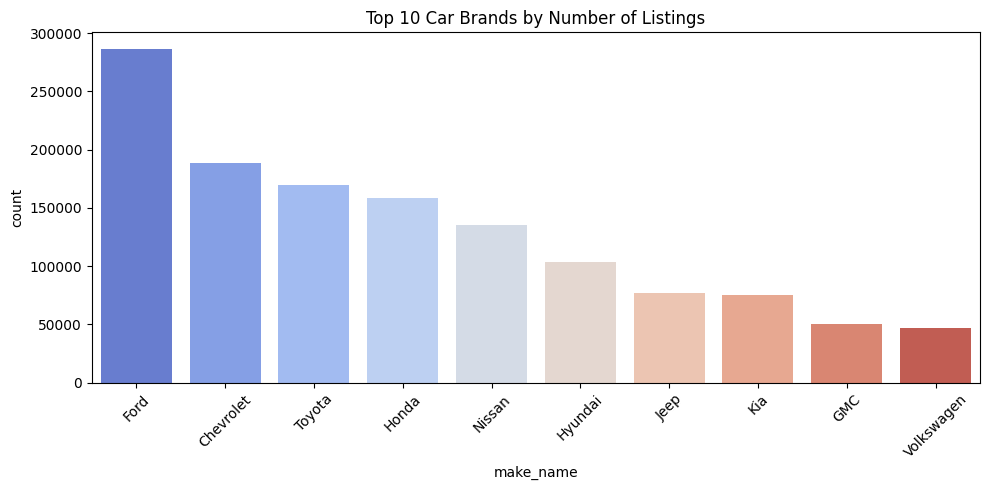

In [ ]:
# importing necessary libraries
import matplotlib.pyplot as plt  # import statement for pyplot
import seaborn as sns
# getting top 10 car brands by number of listings
top_brands = df.groupBy("make_name").count()\
    .orderBy("count", ascending=False).limit(10).toPandas()

# plotting the top brands using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(data=top_brands, x="make_name", y="count", palette="coolwarm")  # x changed to 'make_name' for clarity
plt.title("Top 10 Car Brands by Number of Listings")
plt.xticks(rotation=45)  # rotating x labels to avoid overlap
plt.tight_layout()
plt.show()


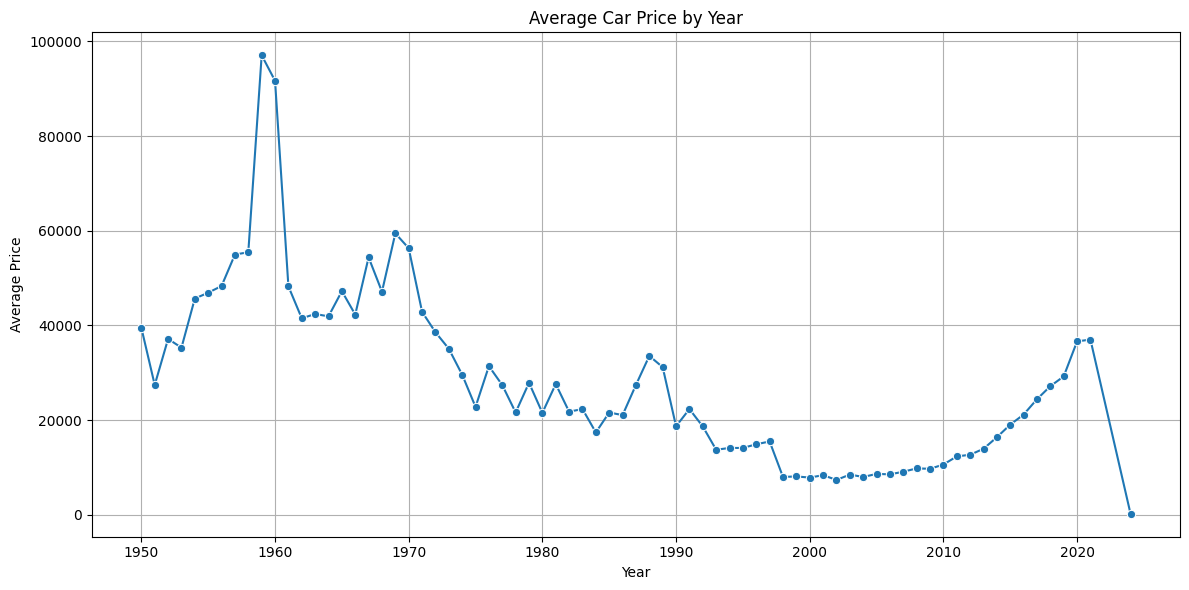

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and collect
avg_price_year = df_valid.groupBy("year").avg("price")\
    .withColumnRenamed("avg(price)", "average_price")\
    .orderBy("year").toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price_year, x="year", y="average_price", marker="o")
plt.title("Average Car Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Trim All String Columns (remove extra spaces)
from pyspark.sql.functions import trim

df = df.select([trim(col(c)).alias(c) if df.schema[c].dataType.simpleString() == "string" else col(c) for c in df.columns])


In [ ]:
# list of columns I want to keep and make sure they don’t have missing values
selected_columns = [
    "price",
    "horsepower",
    "mileage",
    "year",
    "seller_rating",
    "daysonmarket",
    "fuel_type",
    "transmission_display",
    "make_name",
    "model_name",
    "owner_count",
    "body_type",
    "city_fuel_economy",
    "engine_displacement",
    "engine_type",
    "maximum_seating",
    "has_accidents",
    "is_new",
    "power"


]

df = df.dropna(subset=selected_columns)


In [ ]:
rows = df.count()
columns = len(df.columns)
print(f"Rows: {rows}, Columns: {columns}")


Rows: 732319, Columns: 66


In [ ]:
from pyspark.sql.functions import sum, col

# checking how many nulls are there in each of the selected columns
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in selected_columns]).show()


+-----+----------+-------+----+-------------+------------+---------+--------------------+---------+----------+-----------+---------+-----------------+-------------------+-----------+---------------+-------------+------+-----+
|price|horsepower|mileage|year|seller_rating|daysonmarket|fuel_type|transmission_display|make_name|model_name|owner_count|body_type|city_fuel_economy|engine_displacement|engine_type|maximum_seating|has_accidents|is_new|power|
+-----+----------+-------+----+-------------+------------+---------+--------------------+---------+----------+-----------+---------+-----------------+-------------------+-----------+---------------+-------------+------+-----+
|    0|         0|      0|   0|            0|           0|        0|                   0|        0|         0|          0|        0|                0|                  0|          0|              0|            0|     0|    0|
+-----+----------+-------+----+-------------+------------+---------+--------------------+-------

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# List of categorical columns
categorical_cols = ["fuel_type", "transmission_display", "make_name", "model_name",
                    "body_type", "city_fuel_economy", "engine_type",
                    "maximum_seating"]

valid_categorical_cols = []
for cat_col in categorical_cols:
    if df.select(cat_col).distinct().count() > 1:
        valid_categorical_cols.append(cat_col)

# StringIndexers and OneHotEncoders
indexers = [StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid='keep') for c in valid_categorical_cols]
encoders = [OneHotEncoder(inputCol=c + "_indexed", outputCol=c + "_encoded") for c in valid_categorical_cols]

# Final feature columns (encoded + numerical)
numeric_cols = ["horsepower", "mileage", "year", "seller_rating", "daysonmarket",
                "owner_count", "engine_displacement", "has_accidents", "is_new",
                "power", "price"]

feature_cols = [c + "_encoded" for c in valid_categorical_cols] + numeric_cols

# VectorAssembler to combine all features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Complete pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit and transform
model_pipeline = pipeline.fit(df)
# Assuming you have a fitted pipeline_model object
model_pipeline.write().overwrite().save("/content/drive/MyDrive/car_pipeline_model")

df_final = model_pipeline.transform(df)


In [ ]:
print(valid_categorical_cols)

['fuel_type', 'transmission_display', 'make_name', 'model_name', 'body_type', 'city_fuel_economy', 'engine_type', 'maximum_seating']


In [ ]:
from pyspark.ml.regression import LinearRegression

# Use only features and label
data = df_final.select("features", "price")


# Train-test split using df_final instead of df_sample
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Initialize and train model
lr = LinearRegression(labelCol="price", featuresCol="features")
lr_model = lr.fit(train_data)

# Evaluate
predictions = lr_model.evaluate(test_data)
print("RMSE:", predictions.rootMeanSquaredError)
print("R²:", predictions.r2)

RMSE: 2.2790590292616852
R²: 0.999999980073038


In [ ]:
from pyspark.sql.functions import col

# Get predictions from the test data
predicted_df = lr_model.transform(test_data)

# Rename the 'prediction' column to 'predicted_price'
predicted_df = predicted_df.withColumnRenamed("prediction", "predicted_price")

# Show the price, predicted price, and features
predicted_df.select("price", "predicted_price", "features").show(10, truncate=False)

+-------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|price  |predicted_price   |features                                                                                                                                                                                              |
+-------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|19595.0|19595.4265165005  |(1159,[0,7,62,310,1036,1051,1102,1136,1148,1149,1150,1151,1152,1153,1154,1157,1158],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,201.0,6184.0,2017.0,3.8,9.0,1.0,2400.0,201.0,19595.0])                           |
|17778.0|17778.39030199411 |(1159,[0,7,62,310,1036,1051,1102,1136,1148,1149,1150,1151,11

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Use only features and label (same as before)
data = df_final.select("features", "price")

# Train-test split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize Random Forest Regressor
rf = RandomForestRegressor(labelCol="price", featuresCol="features", numTrees=100, seed=42)

# Train the model
rf_model = rf.fit(train_data)


# Make predictions on the test set
predictions = rf_model.transform(test_data)

# Evaluate predictions
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print("Random Forest RMSE:", rmse)
print("Random Forest R²:", r2)


Random Forest RMSE: 7268.39232660335
Random Forest R²: 0.8313918256031105


In [ ]:
from pyspark.sql.functions import col

# Get predictions from the test dataset using the trained linear regression model
predicted_df = rf_model.transform(test_data)

# Rename the 'prediction' column to 'predicted_price' for clarity
predicted_df = predicted_df.withColumnRenamed("prediction", "predicted_price")

# Display the original price, the predicted price, and feature vector for comparison
predicted_df.select("price", "predicted_price", "features").show(10, truncate=False)


+-------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|price  |predicted_price   |features                                                                                                                                                                                   |
+-------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|46590.0|44117.77455033981 |(1159,[0,7,41,99,1037,1044,1103,1136,1148,1149,1150,1151,1152,1153,1154,1157,1158],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,375.0,35062.0,2018.0,3.6444444444444444,48.0,1.0,3500.0,375.0,46590.0])|
|39995.0|39392.439370473505|(1159,[0,7,41,99,1037,1044,1103,1136,1148,1149,1150,1151,1152,1153,1154,1157,1158],[1.0,1.0,1.0,1.0,1.0,

In [ ]:
from pyspark.sql import Row

# Two sample rows with all selected features
sample_rows = [
    Row(price=20000.0, horsepower=150.0, mileage=30000.0, year=2018, seller_rating=4.5, daysonmarket=45,
        fuel_type="gasoline", transmission_display="Automatic", make_name="Toyota", model_name="Camry",
        owner_count=1, body_type="Sedan", city_fuel_economy=28.0, engine_displacement=2.5,
        engine_type="I4", maximum_seating="5", has_accidents=0, is_new=0, power=150.0),

    Row(price=35000.0, horsepower=300.0, mileage=10000.0, year=2021, seller_rating=4.9, daysonmarket=10,
        fuel_type="electric", transmission_display="Automatic", make_name="Tesla", model_name="Model 3",
        owner_count=0, body_type="Sedan", city_fuel_economy=130.0, engine_displacement=0.0,
        engine_type="Electric", maximum_seating="5", has_accidents=0, is_new=1, power=283.0),

    Row(price=18000.0, horsepower=140.0, mileage=45000.0, year=2017, seller_rating=4.2, daysonmarket=60,
        fuel_type="gasoline", transmission_display="Manual", make_name="Honda", model_name="Civic",
        owner_count=2, body_type="Coupe", city_fuel_economy=32.0, engine_displacement=2.0,
        engine_type="I4", maximum_seating="5", has_accidents=1, is_new=0, power=140.0),

    Row(price=27000.0, horsepower=200.0, mileage=20000.0, year=2019, seller_rating=4.6, daysonmarket=30,
        fuel_type="hybrid", transmission_display="CVT", make_name="Ford", model_name="Fusion",
        owner_count=1, body_type="Sedan", city_fuel_economy=42.0, engine_displacement=2.0,
        engine_type="I4 Hybrid", maximum_seating="5", has_accidents=0, is_new=0, power=188.0),

    Row(price=45000.0, horsepower=400.0, mileage=5000.0, year=2022, seller_rating=4.8, daysonmarket=15,
        fuel_type="gasoline", transmission_display="Automatic", make_name="BMW", model_name="M340i",
        owner_count=0, body_type="Sedan", city_fuel_economy=23.0, engine_displacement=3.0,
        engine_type="I6 Turbo", maximum_seating="5", has_accidents=0, is_new=1, power=382.0)
]




In [ ]:
test_df = spark.createDataFrame(sample_rows)
test_df.show()


+-------+----------+-------+----+-------------+------------+---------+--------------------+---------+----------+-----------+---------+-----------------+-------------------+-----------+---------------+-------------+------+-----+
|  price|horsepower|mileage|year|seller_rating|daysonmarket|fuel_type|transmission_display|make_name|model_name|owner_count|body_type|city_fuel_economy|engine_displacement|engine_type|maximum_seating|has_accidents|is_new|power|
+-------+----------+-------+----+-------------+------------+---------+--------------------+---------+----------+-----------+---------+-----------------+-------------------+-----------+---------------+-------------+------+-----+
|20000.0|     150.0|30000.0|2018|          4.5|          45| gasoline|           Automatic|   Toyota|     Camry|          1|    Sedan|             28.0|                2.5|         I4|              5|            0|     0|150.0|
|35000.0|     300.0|10000.0|2021|          4.9|          10| electric|           Automat

In [ ]:
from pyspark.ml import PipelineModel

# Load the pipeline from the exact path used above
pipeline_model = PipelineModel.load("/content/drive/MyDrive/car_pipeline_model")

# Apply it to your test data
transformed_data = pipeline_model.transform(test_df) # Changed variable name to transformed_data

# Use lr_model to get predictions
predictions = lr_model.transform(transformed_data) # Use rf_model to get prediction from transformed data

# Show the prediction results
predictions.select("prediction").show()

+------------------+
|        prediction|
+------------------+
|20005.250246420746|
|35004.382633256224|
|18002.757193885252|
|  26998.5413637882|
| 45007.45525431106|
+------------------+



In [ ]:
from pyspark.ml import PipelineModel

# Load the pipeline from the exact path used above
pipeline_model = PipelineModel.load("/content/drive/MyDrive/car_pipeline_model")

# Apply it to your test data
transformed_data = pipeline_model.transform(test_df) # Changed variable name to transformed_data

# Use rf_model to get predictions
predictions = rf_model.transform(transformed_data) # Use rf_model to get prediction from transformed data

# Show the prediction results
predictions.select("prediction").show()

+------------------+
|        prediction|
+------------------+
| 18495.47898147659|
| 33916.95058571793|
| 17150.91140283755|
|28405.195611899337|
|44266.272482344924|
+------------------+

